In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import cv2
from PIL import Image
from tqdm import tqdm

### Initial check on train.csv

In [24]:
# read csv data
train = pd.read_csv("../data/train.csv")
print(train.shape)
train.head()

(147793, 5)


,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [25]:
train.dtypes

image_id    object
width        int64
height       int64
bbox        object
source      object
dtype: object

In [26]:
# split the bbox into separate columns
bbox = np.vstack(train["bbox"].apply(lambda x: np.fromstring(x[1:-1], sep=",")))
for i, col in enumerate(["xmin", "ymin", "w", "h"]):
    train[col] = bbox[:, i]
train["xmax"] = train["xmin"] + train["w"]
train["ymax"] = train["ymin"] + train["h"]
train.drop(columns=["bbox", "w", "h"], inplace=True)
train.head()

,image_id,width,height,source,xmin,ymin,xmax,ymax
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,890.0,258.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,356.0,606.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,451.0,664.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,943.0,202.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,150.0,261.0


In [29]:
train.isnull().sum()

image_id    0
width       0
height      0
source      0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [31]:
train.describe()

,width,height,xmin,ymin,xmax,ymax
count,147793.0,147793.0,147793.000000,147793.000000,147793.000000,147793.000000
mean,1024.0,1024.0,472.381631,475.386907,556.816691,552.314212
std,0.0,0.0,303.555566,300.815509,302.305344,298.944521
min,1024.0,1024.0,0.000000,0.000000,2.000000,2.000000
25%,1024.0,1024.0,203.000000,213.000000,292.000000,294.000000
50%,1024.0,1024.0,475.000000,477.000000,563.000000,556.000000
75%,1024.0,1024.0,737.000000,737.000000,823.000000,814.000000
max,1024.0,1024.0,1023.000000,1023.000000,1024.000000,1024.000000


- There is no missing value.
- All images are 1024 * 1024.
- All x, y values are within the range 0 ~ 1024.

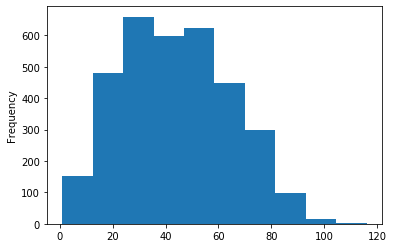

In [44]:
# distribution of number of bboxes
train.groupby("image_id").image_id.count().plot.hist()
plt.show()

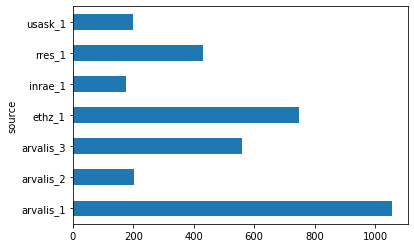

In [49]:
# dsitribution of sources
train.groupby("source").image_id.nunique().plot.barh()
plt.show()

### Initial check on images

In [72]:
# load image file path
image_folder = "../data/train"
image_files = glob.glob(f"{image_folder}/**")

print("Total number of images:", len(image_files))

Total number of images: 3422


In [73]:
# check if all images are in jpg format
def check_format(folder, form=".jpg"):
    """
    Check if all images are in the specified format.
    """
    files = glob.glob(f"{folder}/**")
    format_ct = sum([file.endswith(".jpg") for file in files])
    return len(files) - format_ct

check_format(image_folder)

0

In [66]:
# append .jpg to the image_id
train["image_id"] = train["image_id"].apply(lambda x: str(x) + ".jpg")
train.head()

,image_id,width,height,source,xmin,ymin,xmax,ymax
0,b6ab77fd7.jpg,1024,1024,usask_1,834.0,222.0,890.0,258.0
1,b6ab77fd7.jpg,1024,1024,usask_1,226.0,548.0,356.0,606.0
2,b6ab77fd7.jpg,1024,1024,usask_1,377.0,504.0,451.0,664.0
3,b6ab77fd7.jpg,1024,1024,usask_1,834.0,95.0,943.0,202.0
4,b6ab77fd7.jpg,1024,1024,usask_1,26.0,144.0,150.0,261.0


In [83]:
train.drop(columns=["width", "height", "source"], inplace=True)

In [84]:
# save the new dataset
train.to_csv("wheat.csv", index=False)

In [82]:
# check if all images are indeed 1024 * 1024
def check_size(folder, h=1024, w=1024):
    """
    Check if all images are in the specified size.
    """
    files = glob.glob(f"{folder}/**")
    ct = 0
    for f in tqdm(files):
        try:
            img = cv2.imread(f)
            height, width = img.shape[0], img.shape[1]
            if height != h or width != 1024:
                ct += 1
        except:
            print(f"{f} has problems.")
    return ct

check_size(image_folder)

100%|██████████| 3422/3422 [00:35<00:00, 96.91it/s] 


0

In [92]:
# check how many images don't have bounding boxes
def check_bbox(folder, df):
    """
    Check which images don't have bounding boxes.
    """
    all_files = glob.glob(f"{folder}/**")
    bbox_files = set(df.image_id)
    files_without_bbox = []
    for f in all_files:
        if f.split("/")[-1] not in bbox_files:
            files_without_bbox.append(f)
    return len(files_without_bbox), files_without_bbox

_, images_without_bbox = check_bbox(image_folder, train)
print("Number of images without bounding boxes:", _)

Number of images without bounding boxes: 49


In [158]:
# helper functions following reigHns's notebook
# reference: https://www.kaggle.com/reighns/augmentations-data-cleaning-and-bounding-boxes

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=int(np.ceil(len(img_matrix_list) / ncols)), ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

def draw_rect(img, bboxes, color=(255,0,0)):
    img = img.copy()
    bboxes = bboxes[:, :4]
    bboxes = bboxes.reshape(-1, 4)
    for bbox in bboxes:
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
        img = cv2.rectangle(img.copy(), pt1, pt2, color, int(max(img.shape[:2]) / 200))
    return img

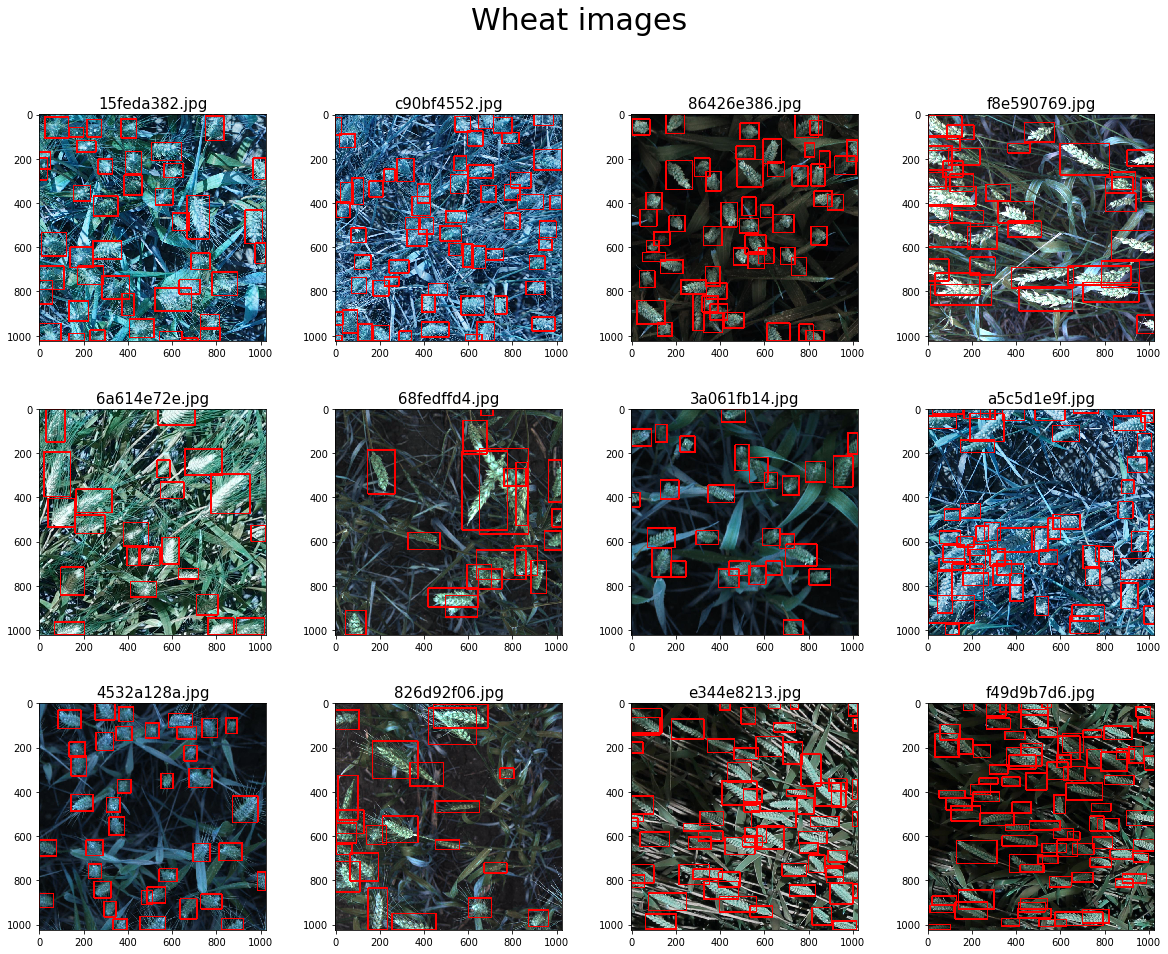

In [159]:
def plot_random(folder, df, bbox=True, num=12):
    """
    Randomly plot images with bounding boxes.
    """
    files = glob.glob(f"{folder}/**")
    random_files = np.random.choice(files, size=num)  # full path of random images
    title_list = [f.split("/")[-1] for f in random_files]  # image_id
    matrix_list = []
    
    # not displaying bounding boxes
    if bbox == False:
        matrix_list = [cv2.imread(f) for f in random_files]
    
    # displaying bounding boxes
    else:
        for i in range(num):
            img = cv2.imread(random_files[i])
            bboxes = df.loc[df.image_id == title_list[i]][["xmin", "ymin", "xmax", "ymax"]].to_numpy()
            # if the image has bounding boxes
            if bboxes.shape[0] > 0:
                matrix_list.append(draw_rect(img, bboxes))
            else:
                matrix_list.append(img)
    
    return plot_multiple_img(matrix_list, title_list, ncols=4, main_title="Wheat images")
    
plot_random(image_folder, train, bbox=True, num=12)

**Note**:

1. Train and test set contain data in different regions.
2. Not all images include wheat heads / bounding boxes.